In [17]:

import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub,plot_line
from collections import defaultdict
import matplotlib.pyplot as plt

n_inflight_flows_divide: 4343


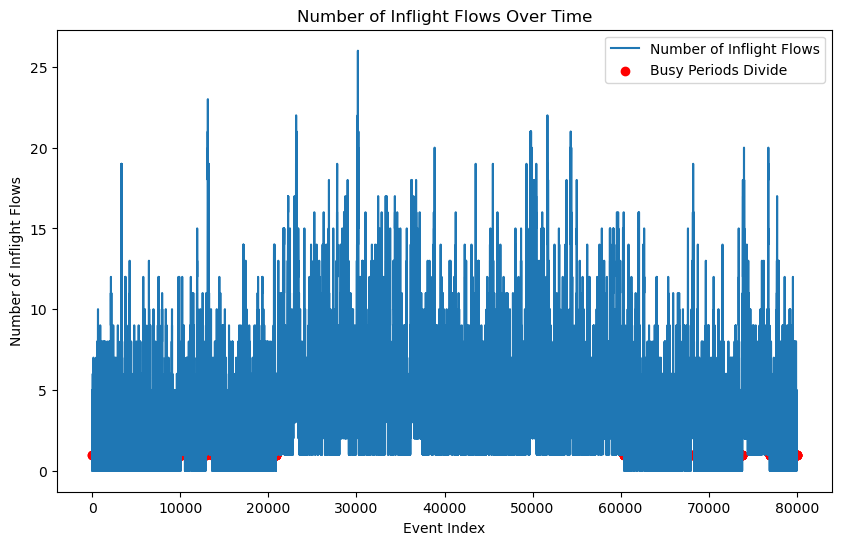

n_flow_event: 80000, 4343 busy periods, n_flows_per_period_est: 1, 1.0, 19767


In [19]:
root_data_dir = '/data2/lichenni/path_perflow_link/shard1562_nflows2000_nhosts21_lr10Gbps/'
topo_type = '_topo-pl-21_s0_i0'
fat=np.load(root_data_dir+'fat.npy')
fid=np.load(root_data_dir+f'fid{topo_type}.npy')
fct=np.load(root_data_dir+f'fct{topo_type}.npy')
nhosts=21

events = []
for i in range(len(fat)):
    events.append((fat[i], 'arrival'))
    events.append((fat[i]+fct[i], 'departure'))
events.sort(key=lambda x: x[0])

n_inflight_flows=0
n_inflight_flows_list=[]
n_inflight_flows_divide=[]
current_busy_period_start_time=None
n_flows=0
busy_periods_time = []
for event_idx,event in enumerate(events):
    time, event_type = event
    n_inflight_flows_list.append(n_inflight_flows)
    if event_type == 'arrival':
        if n_inflight_flows == 0:
            n_flows=0
            current_busy_period_start_time = time
        n_inflight_flows += 1
        n_flows+=1
    elif event_type == 'departure':
        n_inflight_flows -= 1
        if n_inflight_flows == 0:
            if n_flows>0:
                n_inflight_flows_divide.append(event_idx)
                busy_periods_time.append((current_busy_period_start_time, time, n_flows))

# Plotting
print(f"n_inflight_flows_divide: {len(n_inflight_flows_divide)}")
plt.figure(figsize=(10, 6))
plt.plot(n_inflight_flows_list, label='Number of Inflight Flows')
plt.scatter(n_inflight_flows_divide, np.array(n_inflight_flows_list)[n_inflight_flows_divide], color='red', label='Busy Periods Divide')

plt.xlabel('Event Index')
plt.ylabel('Number of Inflight Flows')
plt.title('Number of Inflight Flows Over Time')
plt.legend()
plt.show()
        
busy_periods=[]
busy_periods_len=[]
for busy_period_time in busy_periods_time:
    busy_period_start, busy_period_end, n_flows = busy_period_time
    fid_target_idx=~np.logical_or(
            fat+fct<busy_period_start,
            fat>busy_period_end,
        )
    fid_target=fid[fid_target_idx]
    if np.sum(fid_target)>0:
        busy_periods.append([np.min(fid_target), np.max(fid_target)])
        busy_periods_len.append(n_flows)

print(f"n_flow_event: {len(events)}, {len(busy_periods)} busy periods, n_flows_per_period_est: {np.min(busy_periods_len)}, {np.median(busy_periods_len)}, {np.max(busy_periods_len)}")

n_small_flows: 22084
n_inflight_flows_divide: 17703


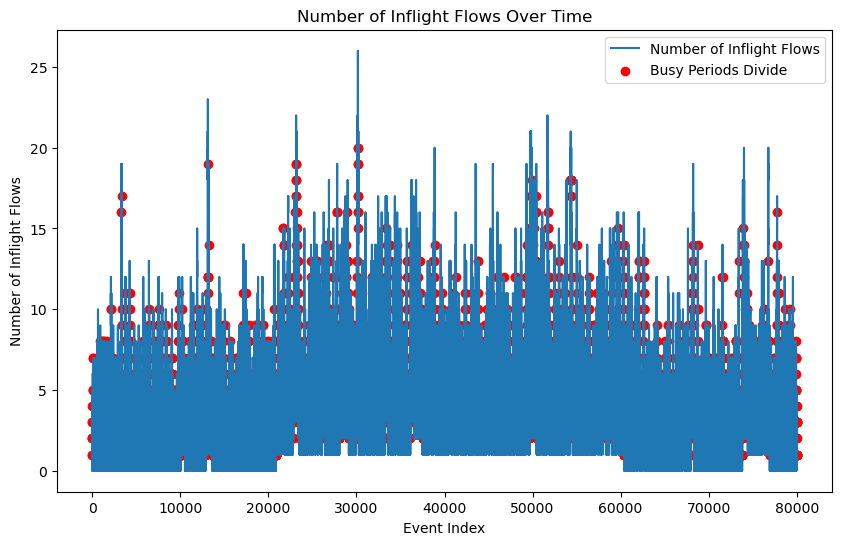

n_flow_event: 80000, 17703 busy periods, n_flows_per_period_est: 1, 3.0, 40


In [37]:
root_data_dir = '/data2/lichenni/path_perflow_link/shard1562_nflows2000_nhosts21_lr10Gbps/'
topo_type = '_topo-pl-21_s0_i0'
fat=np.load(root_data_dir+'fat.npy')
fsize_total=np.load(root_data_dir+'fsize.npy')
fid=np.load(root_data_dir+f'fid{topo_type}.npy')
fct=np.load(root_data_dir+f'fct{topo_type}.npy')
nhosts=21

flows_size_threshold=100000
events = []
flow_to_fsize={}
for i in range(len(fat)):
    events.append((fat[i], 'arrival',fid[i]))
    events.append((fat[i]+fct[i], 'departure',fid[i]))
    flow_to_fsize[fid[i]]=fsize_total[i]
events.sort(key=lambda x: x[0])

n_small_flows=np.sum(fsize_total<flows_size_threshold)
print(f"n_small_flows: {n_small_flows}")
n_inflight_flows=0
n_inflight_flows_list=[]
n_inflight_flows_divide=[]
current_busy_period_start_time=None
n_flows=0
busy_periods_time = []

active_flows=set()
enable_new_period=True
for event_idx,event in enumerate(events):
    time, event_type, flow_id = event
    n_inflight_flows_list.append(n_inflight_flows)
    if event_type == 'arrival':
        n_inflight_flows += 1
        if flow_to_fsize[flow_id]<flows_size_threshold:
            active_flows.add(flow_id)
        if enable_new_period:
            current_busy_period_start_time = time
            enable_new_period=False
    elif event_type == 'departure':
        n_inflight_flows -= 1
        if flow_to_fsize[flow_id]<flows_size_threshold:
            active_flows.remove(flow_id)
        if not enable_new_period:
            if len(active_flows)==0:
                n_inflight_flows_divide.append(event_idx)
                busy_periods_time.append((current_busy_period_start_time, time))
                enable_new_period=True
                # current_busy_period_start_time = time + 1

# Plotting
print(f"n_inflight_flows_divide: {len(n_inflight_flows_divide)}")
plt.figure(figsize=(10, 6))
plt.plot(n_inflight_flows_list, label='Number of Inflight Flows')
plt.scatter(n_inflight_flows_divide, np.array(n_inflight_flows_list)[n_inflight_flows_divide], color='red', label='Busy Periods Divide')

plt.xlabel('Event Index')
plt.ylabel('Number of Inflight Flows')
plt.title('Number of Inflight Flows Over Time')
plt.legend()
plt.show()
        
busy_periods=[]
busy_periods_len=[]
for busy_period_time in busy_periods_time:
    busy_period_start, busy_period_end = busy_period_time
    fid_target_idx=~(np.logical_or(
            fat+fct<=busy_period_start,
            fat>=busy_period_end,
        ))
    fid_target=fid[fid_target_idx]
    # if np.max(fid_target)-np.min(fid_target)+1==19703:
    #     print(fid_target)
    #     fid_target_idx=10425
    #     print(f"{fid_target_idx}: size={fsize_total[fid_target_idx]}, fat={fat[fid_target_idx]}, fct={fct[fid_target_idx]}")
    if np.sum(fid_target)>0:
        busy_periods.append(fid_target)
        busy_periods_len.append(len(fid_target))

print(f"n_flow_event: {len(events)}, {len(busy_periods)} busy periods, n_flows_per_period_est: {np.min(busy_periods_len)}, {np.median(busy_periods_len)}, {np.max(busy_periods_len)}")

In [18]:
dir_input="/data2/lichenni/perflow_path"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(1000):
    for n_flows in [2000]:
        for key_tag in [5]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                
                stats = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                flow_size_dist=stats.item().get("size_dist_candidate")
                max_load=float(stats.item().get("load_bottleneck_target"))
                flow_size_sigma=float(stats.item().get("size_sigma_candidate"))
                
                # if flow_size_dist!='lognorm':continue
                # if max_load>0.8: continue
                # if flow_size_sigma<15000 or flow_size_sigma>40000: continue
                
                key_tag=flow_size_dist
                
                # if max_load<0.35:
                #     key_tag='load=[20%,35%)'
                # elif max_load<0.50:
                #     key_tag='load=[35%,50%)'
                # elif max_load<=0.65:
                #     key_tag='load=[50%,65%)'
                # else:
                #     key_tag='load=[65%,80%)'
                
                # if flow_size_sigma<15000:
                #     key_tag='load=[5K,15K)'
                # elif flow_size_sigma<25000:
                #     key_tag='load=[15K,25K)'
                # elif flow_size_sigma<35000:
                #     key_tag='load=[25K,35K)'
                # else:
                #     key_tag='load=[35K,50K)'
                # key_tag="one"
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid) % n_flows == 0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}, {len(fid)}, {len(set(fid))}, {np.all(fid[:-1] <= fid[1:])}, {len(fid) % n_flows}")
print(f"len(data_list): {len(data_list)}")

fid not valid: shard12_nflows2000_nhosts5_lr10Gbps, 85380, 85337, True, 1380
fid not valid: shard144_nflows2000_nhosts5_lr10Gbps, 70755, 70707, True, 755
fid not valid: shard149_nflows2000_nhosts5_lr10Gbps, 41517, 41516, True, 1517
fid not valid: shard153_nflows2000_nhosts5_lr10Gbps, 94117, 94116, True, 117
fid not valid: shard203_nflows2000_nhosts5_lr10Gbps, 19508, 19505, True, 1508
fid not valid: shard204_nflows2000_nhosts5_lr10Gbps, 99988, 99988, True, 1988
fid not valid: shard368_nflows2000_nhosts5_lr10Gbps, 99825, 99825, True, 1825
fid not valid: shard394_nflows2000_nhosts5_lr10Gbps, 99995, 99995, True, 1995
fid not valid: shard441_nflows2000_nhosts5_lr10Gbps, 56136, 56136, True, 136
fid not valid: shard567_nflows2000_nhosts5_lr10Gbps, 27324, 27320, True, 1324
fid not valid: shard636_nflows2000_nhosts5_lr10Gbps, 88549, 88516, True, 549
fid not valid: shard688_nflows2000_nhosts5_lr10Gbps, 77765, 77761, True, 1765
fid not valid: shard760_nflows2000_nhosts5_lr10Gbps, 99653, 99653, Tr

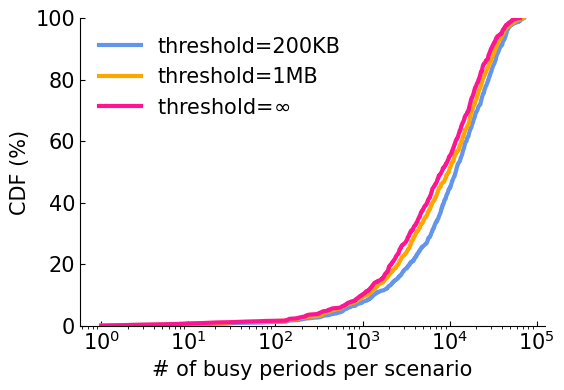

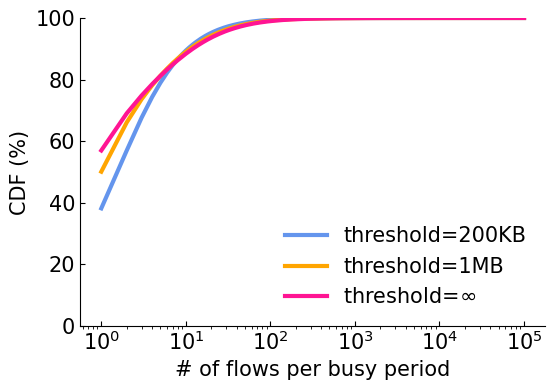

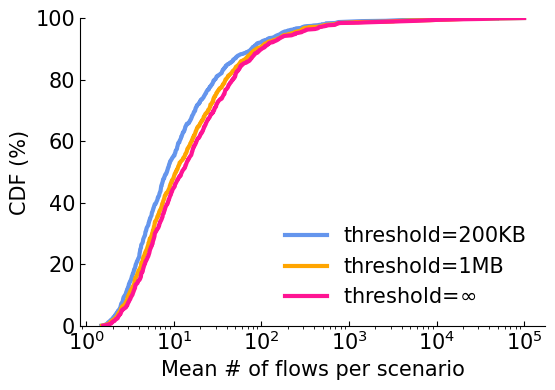

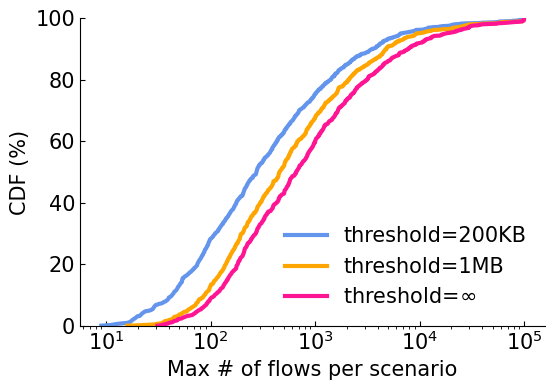

In [19]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
flow_size_threshold_list=[200000,1000000,100000000]
flow_size_threshold_list_label=["200KB", "1MB", "$\infty$"]
for spec_idx,(spec,topo_type,_) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    for flow_size_threshold_idx, flow_size_threshold in enumerate(flow_size_threshold_list):
        key_tag=f"threshold={flow_size_threshold_list_label[flow_size_threshold_idx]}"
        busy_periods=np.load(f'{input_tmp}/period{topo_type}_t{flow_size_threshold}.npy', allow_pickle=True)
        busy_periods=[np.array(period) for period in busy_periods]
        
        num_period_all[key_tag].append(len(busy_periods))
        
        # len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
        len_per_period = np.array([len(period) for period in busy_periods])
        len_per_period_all[key_tag].extend(len_per_period)
        len_per_period_all_mean[key_tag].append(len_per_period.mean())
        len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

max_index=[np.argmax(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

In [20]:
dir_input="/data2/lichenni/perflow_path_empirical"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(200):
    for n_flows in [2000]:
        for key_tag in [5]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                
                stats = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                flow_size_dist=stats.item().get("size_dist_candidate")
                max_load=float(stats.item().get("load_bottleneck_target"))
                # flow_size_sigma=float(stats.item().get("size_sigma_candidate"))
                
                # if flow_size_dist!='lognorm':continue
                # if max_load>0.8: continue
                # if flow_size_sigma<15000: continue
                
                key_tag=flow_size_dist
                
                # if max_load<0.35:
                #     key_tag='load=[20%,35%)'
                # elif max_load<0.50:
                #     key_tag='load=[35%,50%)'
                # elif max_load<=0.65:
                #     key_tag='load=[50%,65%)'
                # else:
                #     key_tag='load=[65%,80%)'
                
                # if flow_size_sigma<15000:
                #     key_tag='load=[5K,15K)'
                # elif flow_size_sigma<25000:
                #     key_tag='load=[15K,25K)'
                # elif flow_size_sigma<35000:
                #     key_tag='load=[25K,35K)'
                # else:
                #     key_tag='load=[35K,50K)'
                # key_tag="one"
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid) % n_flows == 0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}, {len(fid)}, {len(set(fid))}, {np.all(fid[:-1] <= fid[1:])}, {len(fid) % n_flows}")
print(f"len(data_list): {len(data_list)}")

fid not valid: shard64_nflows2000_nhosts5_lr10Gbps, 99922, 99922, True, 1922
len(data_list): 199


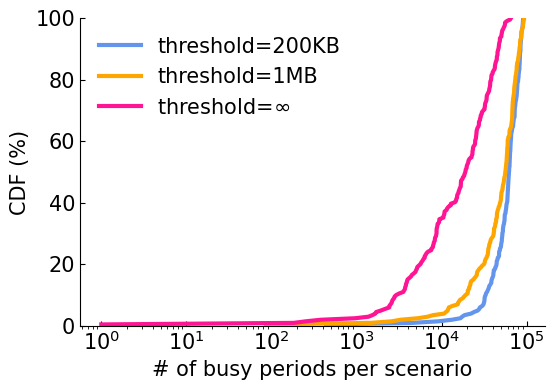

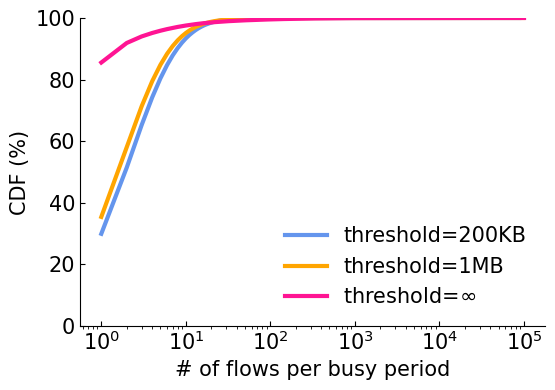

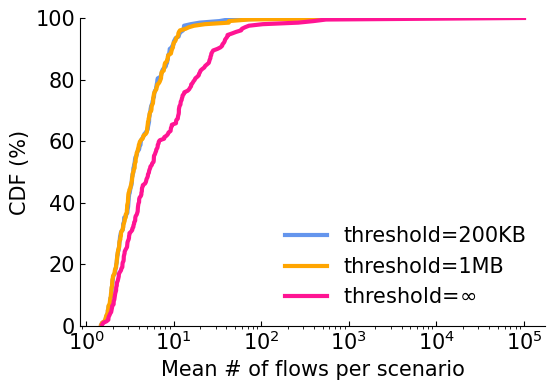

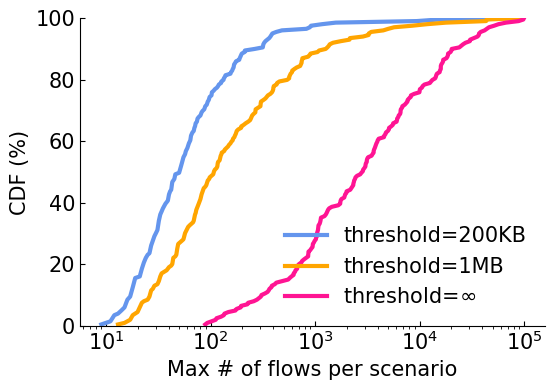

: 

In [21]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
flow_size_threshold_list=[200000,1000000,100000000]
flow_size_threshold_list_label=["200KB", "1MB", "$\infty$"]
for spec_idx,(spec,topo_type,_) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    for flow_size_threshold_idx, flow_size_threshold in enumerate(flow_size_threshold_list):
        key_tag=f"threshold={flow_size_threshold_list_label[flow_size_threshold_idx]}"
        busy_periods=np.load(f'{input_tmp}/period{topo_type}_t{flow_size_threshold}.npy', allow_pickle=True)
        busy_periods=[np.array(period) for period in busy_periods]
        
        num_period_all[key_tag].append(len(busy_periods))
        
        # len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
        len_per_period = np.array([len(period) for period in busy_periods])
        len_per_period_all[key_tag].extend(len_per_period)
        len_per_period_all_mean[key_tag].append(len_per_period.mean())
        len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

max_index=[np.argmax(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

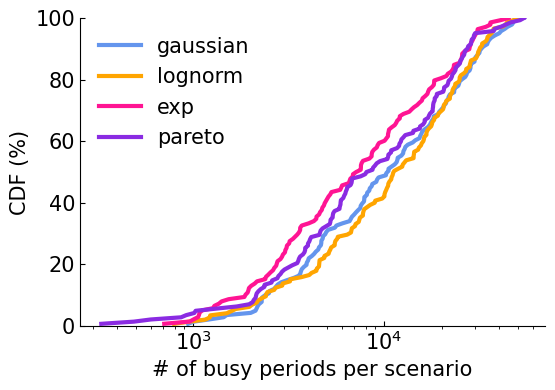

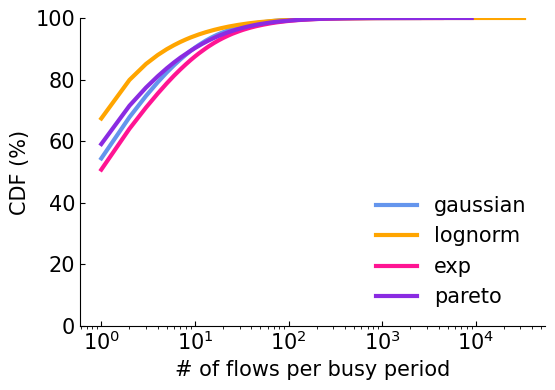

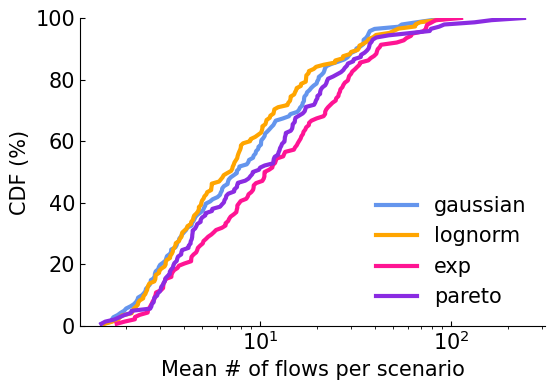

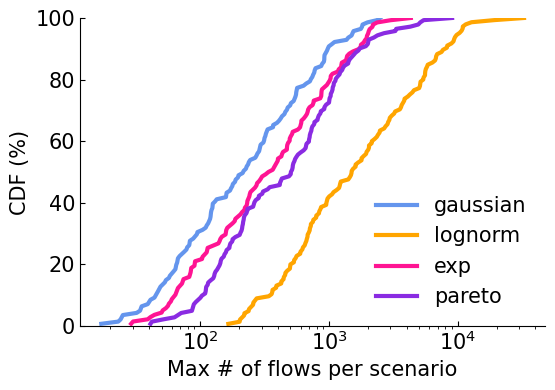

In [16]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
for spec_idx,(spec,topo_type,key_tag) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    busy_periods=np.load(f'{input_tmp}/period{topo_type}_t100000000.npy', allow_pickle=True)
    
    num_period_all[key_tag].append(len(busy_periods))
    
    # len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
    len_per_period = np.array([len(period) for period in busy_periods])
    len_per_period_all[key_tag].extend(len_per_period)
    len_per_period_all_mean[key_tag].append(len_per_period.mean())
    len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

max_index=[np.argmax(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

In [17]:
dir_input="/data2/lichenni/perflow_path_empirical"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(200):
    for n_flows in [2000]:
        for key_tag in [5]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                
                stats = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                flow_size_dist=stats.item().get("size_dist_candidate")
                max_load=float(stats.item().get("load_bottleneck_target"))
                
                # if max_load>0.8: continue
                key_tag=flow_size_dist
                
                # if max_load<0.35:
                #     key_tag='load=[20%,35%)'
                # elif max_load<0.50:
                #     key_tag='load=[35%,50%)'
                # elif max_load<=0.65:
                #     key_tag='load=[50%,65%)'
                # else:
                #     key_tag='load=[65%,80%)'
                
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}")
print(f"len(data_list): {len(data_list)}")

len(data_list): 200


In [ ]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
flow_size_threshold_list=[10000,50000,100000,1000000]
flow_size_threshold_list_label=["10KB", "50KB", "100KB", "1MB"]
for spec_idx,(spec,topo_type,_) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    for flow_size_threshold_idx, flow_size_threshold in enumerate(flow_size_threshold_list):
        key_tag=f"threshold={flow_size_threshold_list_label[flow_size_threshold_idx]}"
        busy_periods=np.load(f'{input_tmp}/period{topo_type}_t{flow_size_threshold}.npy', allow_pickle=True)
        busy_periods=[np.array(period) for period in busy_periods]
        
        num_period_all[key_tag].append(len(busy_periods))
        
        # len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
        len_per_period = np.array([len(period) for period in busy_periods])
        len_per_period_all[key_tag].extend(len_per_period)
        len_per_period_all_mean[key_tag].append(len_per_period.mean())
        len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

max_index=[np.argmax(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

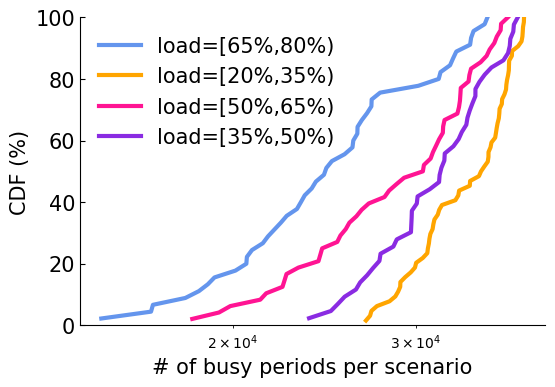

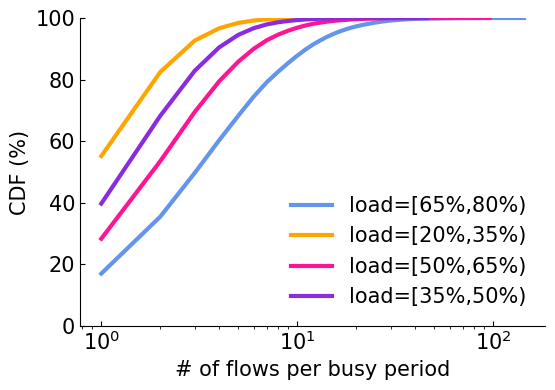

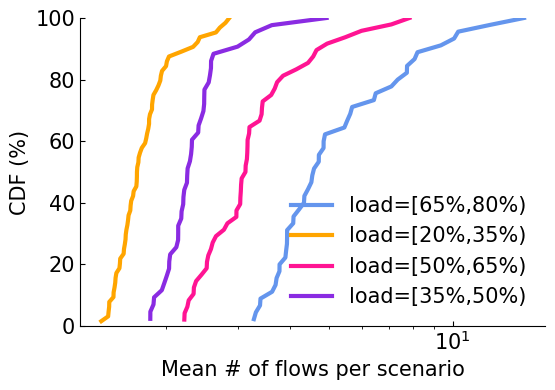

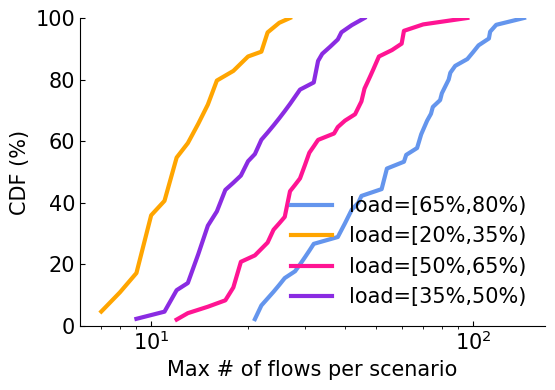

In [8]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
for spec_idx,(spec,topo_type,key_tag) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    busy_periods=np.load(f'{input_tmp}/period{topo_type}.npy', allow_pickle=True)
    
    num_period_all[key_tag].append(len(busy_periods))
    
    # len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
    len_per_period = np.array([len(period) for period in busy_periods])
    len_per_period_all[key_tag].extend(len_per_period)
    len_per_period_all_mean[key_tag].append(len_per_period.mean())
    len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1